<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Bidirectional, Dropout, RepeatVector, TimeDistributed

## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [6]:
df= pd.read_csv('/content/S&P_500_Index_Data.csv',parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [7]:
df.shape

(8192, 2)

In [8]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df.date,y=df.close,mode='lines',name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [9]:
train_size= int (len(df) * 0.8)
test_size = len(df) - train_size
train , test= df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [11]:
def create_sequences(X, y, time_steps=1):
    Xs, ys=[], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
time_steps=30

X_train, y_train= create_sequences(train[['close']], train.close, time_steps)
X_test, y_test= create_sequences(test[['close']], test.close, time_steps)

In [13]:
print(X_train.shape)

(6523, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [14]:
timesteps= X_train.shape[1]
num_features= X_train.shape[2]

In [15]:
model = Sequential([
    Bidirectional(LSTM(128,input_shape=(timesteps,num_features))),
    Dropout(0.2),
    RepeatVector(timesteps),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])
model.compile(loss='mae',optimizer='adam')

## Task 6: Train the Autoencoder

In [16]:
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history = model.fit(
    X_train,y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 32s 172ms/step - loss: 0.1336 - val_loss: 0.1635
Epoch 2/100
184/184 [==============================] - 29s 157ms/step - loss: 0.1039 - val_loss: 0.0723
Epoch 3/100
184/184 [==============================] - 29s 159ms/step - loss: 0.0805 - val_loss: 0.0946
Epoch 4/100
184/184 [==============================] - 29s 159ms/step - loss: 0.0806 - val_loss: 0.0644
Epoch 5/100
184/184 [==============================] - 29s 160ms/step - loss: 0.0716 - val_loss: 0.0983
Epoch 6/100
184/184 [==============================] - 36s 195ms/step - loss: 0.0723 - val_loss: 0.0626
Epoch 7/100
184/184 [==============================] - 31s 167ms/step - loss: 0.0680 - val_loss: 0.0669
Epoch 8/100
184/184 [==============================] - 30s 164ms/step - loss: 0.0670 - val_loss: 0.0392
Epoch 9/100
184/184 [==============================] - 31s 166ms/step - loss: 0.0636 - val_loss: 0.0435
Epoch 10/100
184/184 [==============================] - 31s 166m

## Task 7: Plot Metrics and Evaluate the Model

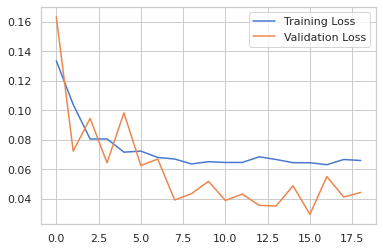

In [17]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [18]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [19]:
model.evaluate(X_test,y_test)

51/51 [==============================] - 2s 41ms/step - loss: 0.3335


0.3335078954696655

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



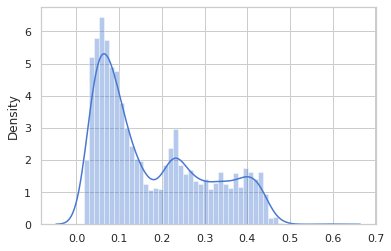

In [20]:
sns.distplot(train_mae_loss, bins=50,kde=True)

In [21]:
threshold = 0.65

In [23]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [24]:
test_score_df= pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [25]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.057293,0.65,False
6584,2012-02-09,1.221625,0.057085,0.65,False
6585,2012-02-10,1.199313,0.056613,0.65,False
6586,2012-02-13,1.221194,0.056610,0.65,False
6587,2012-02-14,1.218150,0.053913,0.65,False


In [26]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.607291,0.65,False
8188,2018-06-26,4.507583,0.674027,0.65,True
8189,2018-06-27,4.451431,0.674384,0.65,True
8190,2018-06-28,4.491406,0.710393,0.65,True
8191,2018-06-29,4.496343,0.683843,0.65,True


In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                        mode='lines',name='Test Loss'))

fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                        mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)

In [28]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.749529,0.65,True
7475,2015-08-26,2.632149,0.791932,0.65,True
8091,2018-02-06,4.440671,0.868147,0.65,True
8092,2018-02-07,4.408365,0.809491,0.65,True
8093,2018-02-08,4.167127,0.802261,0.65,True


In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                        mode='lines',name='Close price'))

fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                        mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True)